In [1]:
import scipy.io as spio
import matplotlib.pyplot as plt
import numpy as np
import random
from scipy import sparse
from sklearn.cluster import KMeans
import online_dictionary_learning.omp as omp

In [1]:
IP_data_mat=spio.loadmat("data/IP/Indian_pines_corrected.mat")
IP_gt_mat=spio.loadmat("data/IP/Indian_pines_gt.mat")
IP_image=IP_data_mat["indian_pines_corrected"]
IP_gt=IP_gt_mat['indian_pines_gt']

pavia_mat = spio.loadmat('data/PaviaU/PaviaU.mat')
pavia_gt_mat = spio.loadmat('data/PaviaU/PaviaU_gt.mat')
pavia_image = pavia_mat['paviaU']
pavia_gt = pavia_gt_mat['paviaU_gt']

salinas_mat = spio.loadmat('data/Salinas/salinas.mat')
salinas_gt_mat = spio.loadmat('data/Salinas/salinas_gt.mat')
salinas_image = salinas_mat['salinasA_corrected']
salinas_gt = salinas_gt_mat['salinasA_gt']
new_salinas=np.ones((84, 88, 204))
new_salinas_gt = np.zeros((84, 88))
new_salinas[:83,:86,:]=salinas_image
new_salinas_gt[:83,:86]=salinas_gt
salinas_image=new_salinas
salinas_gt=new_salinas_gt

IP_dictionary = np.load('results/440_5_10000_dictionary.npy')
#IP_dictionary = np.load('results/Dictionaries/IP_dictionary_k600_t1000_L5_eps001_tile5_JSR.npy')
#IP_dictionary = np.load('results/Dictionaries/IP_dictionary_k440_t1000_L5_eps001_tile5_JSR.npy')
#salinas_dictionary = np.load('results/440_5_10000_salinas.npy')
#salinas_dictionary = np.load('results/Dictionaries/salinas_dictionary_k600_t1000_L5_eps001_tile2_JSR.npy')
salinas_dictionary = np.load('results/1000_3_10000_salinas.npy')
pavia_dictionary = np.load('results/260_3_10000_pavia.npy')
#pavia_dictionary = np.load('results/Dictionaries/pavia_dictionary_k440_t1000_L5_eps01_tile10_JSR.npy')

NameError: name 'spio' is not defined

In [3]:
def kmeans_compare(image, gt, dictionary, verbose=False):
    # Original shape of image
    original_shape = gt.shape
    # flatten image and gt data
    image_flat = np.reshape(image, (-1, image.shape[2]))
    gt_flat = np.reshape(gt, (-1))
    # Remove Misc. Data
    image_flat = image_flat[gt_flat!=0]
    
    # Compute Sparse Coefficients
    coefs = np.zeros((image_flat.shape[0], dictionary.shape[1]))
    
    if verbose:
        print('Computing sparse coefficients:\n')
    
    for i in range(coefs.shape[0]):
        coefs[i]=omp.omp(dictionary, image_flat[i], L=5, eps=None)
        if verbose:
            if i+1<image_flat.shape[0]:
                print('[' + str(i+1) + '] ' + str(np.round(((i+1)/image_flat.shape[0])*100,2)) + '%', end='\r')
            else:
                print('[' + str(i+1) + '] ' + str(np.round(((i+1)/image_flat.shape[0])*100,2)) + '%', end='\n')

    # Run K-Means for both data sets
    k = np.unique(gt_flat).shape[0]-1
    kmeans_o = KMeans(n_clusters=k, random_state=0).fit(image_flat)
    kmeans_s = KMeans(n_clusters=k, random_state=0).fit(coefs)
    
    # Get labels
    labels_o = kmeans_o.labels_
    labels_s = kmeans_s.labels_
    
    # Reconstruct Images
    
    count, loc, n = 0, 0, gt_flat.shape[0]
    final_o, final_s = np.zeros(n), np.zeros(n)
    while count<labels_o.shape[0]:
        if (gt_flat[loc]!=0):
            final_o[loc]=labels_o[count]+1
            final_s[loc]=labels_s[count]+1
            count+=1
        loc+=1
    

    # Reshape
    final_o, final_s = np.reshape(final_o, original_shape), np.reshape(final_s, original_shape)
    
    # Return
    return [final_o, final_s]

In [4]:
IP_class = kmeans_compare(IP_image, IP_gt, IP_dictionary, verbose=False)
salinas_class = kmeans_compare(salinas_image, salinas_gt, salinas_dictionary, verbose=False)
pavia_class = kmeans_compare(pavia_image, pavia_gt, pavia_dictionary, verbose=False)

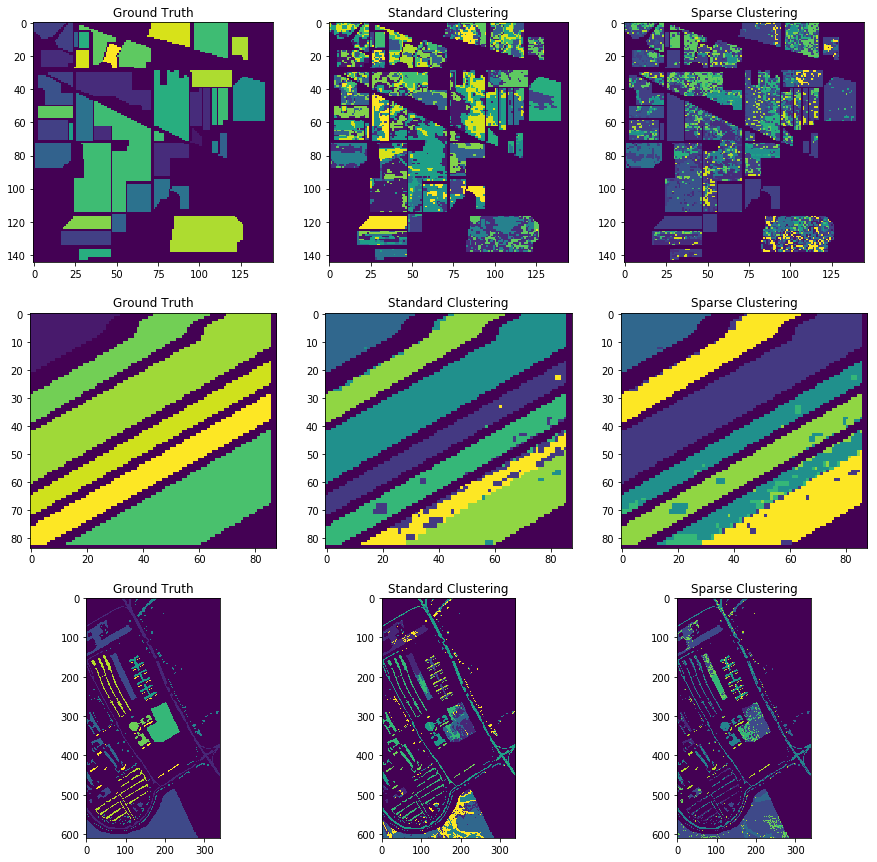

In [5]:
f, (ax1,ax2,ax3) = plt.subplots(3,3, figsize=(15,15))
ax1[0].title.set_text('Ground Truth')
ax1[0].imshow(IP_gt)
ax1[1].title.set_text('Standard Clustering')
ax1[1].imshow(IP_class[0])
ax1[2].title.set_text('Sparse Clustering')
ax1[2].imshow(IP_class[1])
ax2[0].title.set_text('Ground Truth')
ax2[0].imshow(salinas_gt)
ax2[1].title.set_text('Standard Clustering')
ax2[1].imshow(salinas_class[0])
ax2[2].title.set_text('Sparse Clustering')
ax2[2].imshow(salinas_class[1])
ax3[0].title.set_text('Ground Truth')
ax3[0].imshow(pavia_gt)
ax3[1].title.set_text('Standard Clustering')
ax3[1].imshow(pavia_class[0])
ax3[2].title.set_text('Sparse Clustering')
ax3[2].imshow(pavia_class[1])
plt.show()